In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as  plt
import numpy as np
import geopandas as gpd

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

import warnings
warnings.filterwarnings(action='ignore') 

# 데이터 불러오기

In [ ]:


# 데이터 파일 읽기
case_df = pd.read_csv('./Case.csv')
patient_info_df = pd.read_csv('./PatientInfo.csv')
policy_df = pd.read_csv('./Policy.csv')
region_df = pd.read_csv('./Region.csv')
search_trend_df = pd.read_csv('./SearchTrend.csv')
seoul_floating_df = pd.read_csv('./SeoulFloating.csv')
time_df = pd.read_csv('./Time.csv')
time_age_df = pd.read_csv('./TimeAge.csv')
time_gender_df = pd.read_csv('./TimeGender.csv')
time_province_df = pd.read_csv('./TimeProvince.csv')





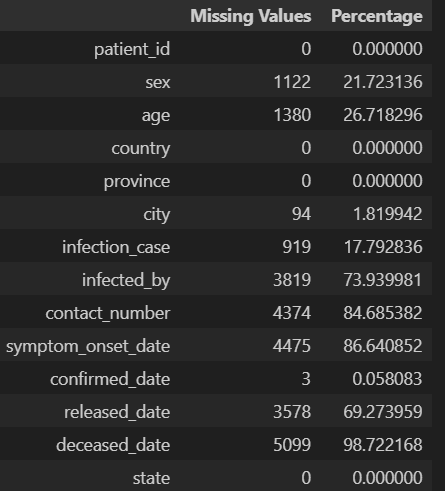

# patient_info_df (PatientInfo.csv) 데이터 전처리 

# 결측치 채우기

In [289]:

# 날짜 형식 변환
patient_info_df['confirmed_date'] = pd.to_datetime(patient_info_df['confirmed_date'])
patient_info_df['released_date'] = pd.to_datetime(patient_info_df['released_date'])

# 결측치 비율 계산
missing_values_count = patient_info_df.isna().sum()
total_cells = patient_info_df.shape[0]
missing_percentage = (missing_values_count / total_cells) * 100

# 결측치가 70% 이상인 열 제거
columns_to_drop = missing_percentage[missing_percentage >= 70].index
patient_info_df_cleaned = patient_info_df.drop(columns=columns_to_drop)



# 나이의 결측치 채우기
age_distribution = patient_info_df_cleaned['age'].value_counts(normalize=True)
age_missing_count = patient_info_df_cleaned['age'].isna().sum()
age_fill_values = np.random.choice(age_distribution.index, size=age_missing_count, p=age_distribution.values)
patient_info_df_cleaned.loc[patient_info_df_cleaned['age'].isna(), 'age'] = age_fill_values

# 성별의 결측치 채우기
gender_distribution = patient_info_df_cleaned['sex'].value_counts(normalize=True)
gender_missing_count = patient_info_df_cleaned['sex'].isna().sum()
gender_fill_values = np.random.choice(gender_distribution.index, size=gender_missing_count, p=gender_distribution.values)
patient_info_df_cleaned.loc[patient_info_df_cleaned['sex'].isna(), 'sex'] = gender_fill_values

# 격리 기간 계산
patient_info_df_cleaned['quarantine_days'] = (patient_info_df_cleaned['released_date'] - patient_info_df_cleaned['confirmed_date']).dt.days

# 격리기간의 평균
average_quarantine_days = patient_info_df_cleaned['quarantine_days'].mean()

# 결측된 released_date 채우기
missing_release_date = patient_info_df_cleaned['released_date'].isna()
patient_info_df_cleaned.loc[missing_release_date, 'released_date'] = patient_info_df_cleaned.loc[missing_release_date, 'confirmed_date'] + pd.to_timedelta(average_quarantine_days, unit='d')

# 결측된 confirmed_date 채우기
confirmed_date_median = patient_info_df_cleaned['confirmed_date'].median()
patient_info_df_cleaned['confirmed_date'].fillna(confirmed_date_median, inplace=True)

# released_date 다시 계산 (새로운 confirmed_date 채워진 후)
missing_release_date = patient_info_df_cleaned['released_date'].isna()
patient_info_df_cleaned.loc[missing_release_date, 'released_date'] = patient_info_df_cleaned.loc[missing_release_date, 'confirmed_date'] + pd.to_timedelta(average_quarantine_days, unit='d')


# released_date 형식 변경 (년-월-일)
patient_info_df_cleaned['released_date'] = patient_info_df_cleaned['released_date'].dt.strftime('%Y-%m-%d')
# 결과 확인
missing_values_count_cleaned = patient_info_df_cleaned.isna().sum()
missing_percentage_cleaned = (missing_values_count_cleaned / total_cells) * 100

# # 결측치 수와 퍼센테이지를 데이터 프레임으로 결합
# missing_data = pd.DataFrame({
#     'Missing Values': missing_values_count_cleaned,
#     'Percentage': missing_percentage_cleaned
# })

# print(missing_data)


# 격리 기간 칼럼은 제거 - released date를 다 채웠기 때문
if 'quarantine_days' in patient_info_df_cleaned.columns:
    patient_info_df_cleaned = patient_info_df_cleaned.drop(columns=['quarantine_days'])

patient_info_df_cleaned.isna().sum()


# `infection_case`의 항목들 출력
infection_case_values = patient_info_df_cleaned['infection_case'].value_counts(dropna=False)
# print(infection_case_values)

# 100개 이하 항목들을 "OTHERS"로 대체
infection_case_values_to_replace = infection_case_values[infection_case_values <= 100].index
patient_info_df_cleaned['infection_case'] = patient_info_df_cleaned['infection_case'].replace(infection_case_values_to_replace, 'OTHERS')

# `NaN` 값을 100개 이상인 항목들의 비율에 맞게 채우기
infection_case_distribution = patient_info_df_cleaned['infection_case'].value_counts(normalize=True)
na_count = patient_info_df_cleaned['infection_case'].isna().sum()
fill_values = np.random.choice(infection_case_distribution.index, size=na_count, p=infection_case_distribution.values)
patient_info_df_cleaned.loc[patient_info_df_cleaned['infection_case'].isna(), 'infection_case'] = fill_values



# 나라는 한국이니 country 칼럼 삭제
if 'country' in patient_info_df_cleaned.columns:
    patient_info_df_cleaned = patient_info_df_cleaned.drop(columns=['country'])

# city - 도시는 너무 세세하게 나눠지므로 삭제
if 'city' in patient_info_df_cleaned.columns:
    patient_info_df_cleaned = patient_info_df_cleaned.drop(columns=['city'])



# 결과 확인
missing_values_count_cleaned = patient_info_df_cleaned.isna().sum()
missing_percentage_cleaned = (missing_values_count_cleaned / total_cells) * 100

# 결측치 수와 퍼센테이지를 데이터 프레임으로 결합
missing_data = pd.DataFrame({
    'Missing Values': missing_values_count_cleaned,
    'Percentage': missing_percentage_cleaned
})


patient_info_df_cleaned['province'].value_counts()

province
Seoul                1312
Gyeongsangbuk-do     1254
Gyeonggi-do          1208
Incheon               343
Chungcheongnam-do     168
Busan                 151
Daegu                 137
Gyeongsangnam-do      133
Daejeon               119
Gangwon-do             63
Chungcheongbuk-do      56
Ulsan                  55
Sejong                 51
Gwangju                44
Jeollabuk-do           27
Jeollanam-do           25
Jeju-do                19
Name: count, dtype: int64

# 도(17개)
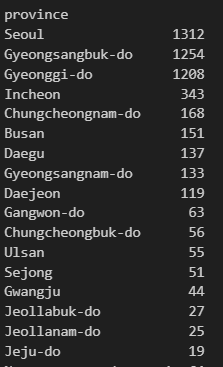

In [ ]:
print(patient_info_df_cleaned.isna().sum())
# 결측치 제거 완료


In [ ]:
# 나이 분포 그래프
plt.figure(figsize=(7, 3))
sns.histplot(patient_info_df_cleaned['age'], bins=30, kde=False)
plt.title('나이 분포')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


# 성별 분포 그래프
plt.figure(figsize=(7, 3))
sns.countplot(x='sex', data=patient_info_df_cleaned)
plt.title('성별 분포')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


# 도넛 차트 - infection_case 분포
plt.figure(figsize=(8, 8))
infection_case_counts = patient_info_df_cleaned['infection_case'].value_counts()
plt.pie(infection_case_counts, labels=infection_case_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('감염경로')
plt.show()



In [290]:
# import pandas as pd
# import folium
# from folium.plugins import MarkerCluster

# # 데이터 파일 읽기
# region_df = pd.read_csv('region.csv')

# # 같은 province 값을 가지는 데이터 포인트들의 평균 위도와 경도 계산
# avg_coordinates = region_df.groupby('province')[['latitude', 'longitude']].mean().reset_index()

# # 지도 생성
# m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# # MarkerCluster를 사용하여 점들을 추가
# marker_cluster = MarkerCluster().add_to(m)

# # 각 province의 평균 위치에 마커 추가
# for idx, row in avg_coordinates.iterrows():
#     folium.Marker(
#         location=[row['latitude'], row['longitude']],
#         popup=row['province'],
#         tooltip=row['province']
#     ).add_to(marker_cluster)

# # 지도 저장
# m.save('korea_provinces_map.html')


In [301]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.colors as mcolors

# 데이터 파일 읽기
region_df = pd.read_csv('region.csv')

# 같은 province 값을 가지는 데이터 포인트들의 평균 위도와 경도 계산
avg_coordinates = region_df.groupby('province')[['latitude', 'longitude']].mean().reset_index()

# 환자 정보 데이터
# patient_info_df_cleaned 데이터프레임이 이미 생성되어 있다고 가정합니다.
province_counts = patient_info_df_cleaned['province'].value_counts().reset_index()
province_counts.columns = ['province', 'count']

# avg_coordinates에 환자 수 데이터 병합
avg_coordinates = avg_coordinates.merge(province_counts, on='province', how='left').fillna(0)

# 지도 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# 색상 농도 계산을 위한 max count 값
max_count = avg_coordinates['count'].max()

# 색상 그라데이션 설정 (빨간색에서 파란색으로)
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "blue"])

# 각 province의 평균 위치에 마커 추가
for idx, row in avg_coordinates.iterrows():
    # 색상 농도 계산
    normalized_count = row['count'] / max_count
    fill_color = mcolors.to_hex(cmap(normalized_count))
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['count'] / 50,  # 환자 수에 따라 마커 크기 조정
        color=fill_color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.6
    ).add_to(m)
    folium.map.Marker(
        [row['latitude'], row['longitude']],
        icon=folium.DivIcon(
            icon_size=(70,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 12pt; color : black">{int(row["count"])}</div>',
        )
    ).add_to(m)

# Jupyter Notebook에서 지도를 표시
m.save('korea_provinces_map.html')
m


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 예시 데이터 준비 (여기서는 날짜와 확진자 수 데이터가 있다고 가정)
data = {
    'date': pd.date_range(start='2020-01-01', periods=100, freq='D'),
    'confirmed_cases': np.random.poisson(lam=10, size=100).cumsum()
}
df = pd.DataFrame(data)

# 날짜를 숫자로 변환
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# 독립 변수와 종속 변수 설정
X = df[['date_ordinal']]
y = df['confirmed_cases']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['confirmed_cases'], label='Actual Data')
plt.plot(df['date'][X_test.index], y_pred, label='Predicted Data', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Confirmed Cases Prediction')
plt.legend()
plt.show()
